<a href="https://colab.research.google.com/github/hallam-flda/gambling_market_analyses/blob/main/Roulette_%26_Customer_Budgets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Budget Constraints and Casino Profitability - A Simulation Based Approach**



## **Introduction**
During my time working in industry, it had been consistently observed that actual margin performance almost always exceeds theoretical margin performance.

More recently we discussed the possibility that this could be caused by budget constraints by both parties. I.e. The reason the Martingale strategy does not work for most gamblers is they do not have infinite budgets, nor would the casino lay a near-infinite bet.

I want to investigate the relationship between margin application and profitability when introducing these constraints.



## **Theoretical RTP**

For this exercise I will be using the example of a European Roulette table, with the only bet-type allowed being a single-number selection.

On a European Roulette wheel there are 37 numbers from 0-36 with a correct selection paying out at odds of 35/1 meaning the expected value for any spin on the roulette table is given by the formula:

$$-1 \times \left(\frac{36}{37}\right) + 35 \times \left(\frac{1}{37}\right) = -2.70\%$$

Therefore the expected profit for the casino is +2.70%, **however**, while the expected value gives us the expected returns of any individual spin, we can only expect to see this achieved for any individual gambler over a sufficiently large sample size.

In reality, individual gamblers will play for as long as their budget allows or until they feel they have reached a level of gameplay they are satisfied with. The likelihood is the session will be longer for those who experience wins and they have more opportunity to converge to the true expected value versus those who continually lose and are not able to converge.

This drop-off in the player base due to budget constraints creates a divergence from theoreitical RTP for the Casino. This can cause issues when using theoretical margin to predict profit for the Casino. The purpose of this notebook is to attempt to quantify that ineffeciency in the simplest example.



## **Basic Roulette Game**

In Python we can create a basisc roulette spin function. It follows the rules of European Roulette and pays out when two randomly selected integers from 0 to 36 are the equal.

For ease of analysis I have assumed every customer stakes £1 and does not adjust their stake depending on whether they are losing or winning.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [ ]:
def european_roulette_simulation(stake=1):
    """
    Simulates a coin flip game and calculates the total winnings/losses.

    Parameters:
    - stake : The value of each spin, defaults to £1 for ease of anaylsis.

    Returns:
    - winnings: The amount that is returned to the player once playing the game.
    """
    # where player selection and outcome are both randomly selected numbers beteen 0-36
    player_selection = random.randint(0,36)
    outcome = random.randint(0,36)

    if outcome == player_selection:
        winnings = 35 * stake
    else:
        winnings = 0 - stake

    return winnings

In [ ]:
# test the function
total_winnings = 0
for _ in range(100000):
  total_winnings += european_roulette_simulation(1)


print(total_winnings)
print(f'for 10,000 spins the casino RTP is {-total_winnings/100000:.2%} versus a theoretical RTP of 2.70%')

-3340
for 10,000 spins the casino RTP is 3.34% versus a theoretical RTP of 2.70%


In isolation for one customer with 100,000 spins, the RTP looks to be reasonable, however, the casino will have lots of customers and so we should extend the simulation.

In [ ]:
players = 1000
spins = 10000

In [ ]:
customer_balances = []
customer_balance_history = []


for _ in range(players):
  total_winnings = 0
  running_history = []
  for _ in range(spins):
    total_winnings += european_roulette_simulation(1)
    # add the current balance to this customer's balance history
    running_history.append(total_winnings)
  customer_balances.append(total_winnings)
  customer_balance_history.append(running_history)

# Casino perspective for plotting
casino_customer_balances = [-x for x in customer_balances]


In [ ]:
drive_path = '/content/drive/My Drive/Colab Notebooks/Roulette Simulation Data/'

In [ ]:
# import os
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

# # Define the directory path in your Google Drive
# drive_path = '/content/drive/My Drive/Colab Notebooks/Roulette Simulation Data/'

# # Create the directory if it doesn't exist
# if not os.path.exists(drive_path):
#     os.makedirs(drive_path)
#     print(f"Directory '{drive_path}' created successfully.")
# else:
#     print(f"Directory '{drive_path}' already exists.")

# # Convert your lists to NumPy arrays
# data_array1 = np.array(customer_balances)
# data_array2 = np.array(customer_balance_history)
# data_array3 = np.array(casino_customer_balances)

# # Save the arrays to Google Drive
# np.save(drive_path + 'customer_balances.npy', data_array1)
# np.save(drive_path + 'customer_balance_history.npy', data_array2)
# np.save(drive_path + 'casino_customer_balances.npy', data_array3)

# print("Data saved to Google Drive.")

In [ ]:
# Customer balances
cb1 = np.load(f'{drive_path}customer_balances.npy')
# History customer balances
cb1_history = np.load(f'{drive_path}customer_balance_history.npy')
# Casino balances
cb2 = np.load(f'{drive_path}casino_customer_balances.npy')

Below the results of the simulation have been plotted, note that even with 10,000,000 spins, there is still some difference between the achieved margin and the theoretical margin due to noise.

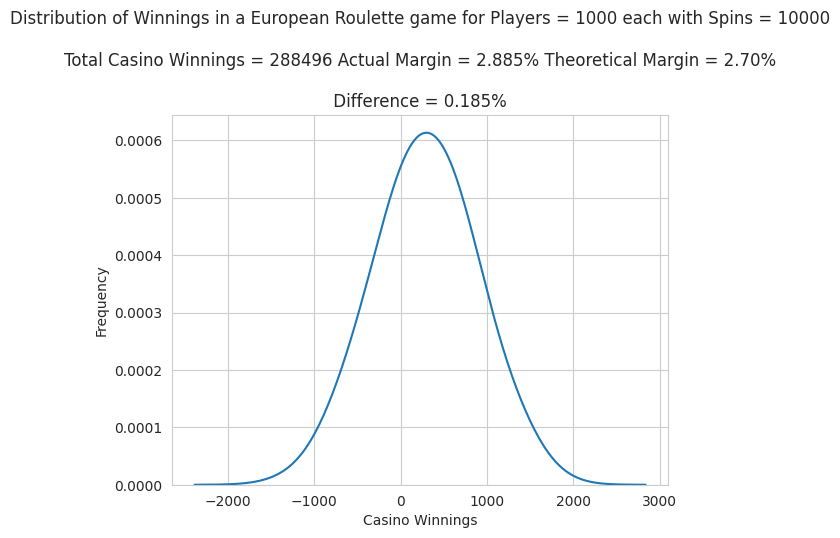

In [ ]:
# plot results on density plot
sns.set_style('whitegrid')
sns.kdeplot(cb2, bw_method=0.5)
plt.xlabel('Casino Winnings')
plt.ylabel('Frequency')
plt.title(f'''Distribution of Winnings in a European Roulette game for Players = {players} each with Spins = {spins}
          \nTotal Casino Winnings = {sum(cb2)} Actual Margin = {(sum(cb2)/(players*spins)):.3%} Theoretical Margin = 2.70%
          \n Difference = {((sum(cb2)/(players*spins))-.0270):.3%} ''')

plt.show()

### **Variance Within the Sample**
We have constructed a basic roulette function with 1,000 players playing 10,000 spins each. Here we have assumed that both the casino and the player have unlimited tolerance for variance. In reality it is likely that the players responsible for populating the far right of the distribution would have given up long before losing £2000.

Conversely we can reasonably assume in the example of a £1 roulette table, the casino would continue to lay any bet because the liability is tolerable.

Consider the below plot demonstrating the variability of customer journeys for n=10 customers.

In [ ]:
def random_selection(balance_list, history_list, n=10):

    # Generate n random indices within the valid range of the balance_list
    rand_indices = random.sample(range(len(balance_list)), n)

    # Use the random indices to select elements from both lists
    selected_balances = [balance_list[i] for i in rand_indices]
    selected_histories = [history_list[i] for i in rand_indices]

    return selected_balances, selected_histories

customer_balance_sample, customer_balance_history_sample = random_selection(cb1, cb1_history)

In [ ]:
#rename to match code from previous save session
x1 = customer_balance_sample
x2 = customer_balance_history_sample

In [ ]:
x1

[44, -136, -676, 728, 80, -1468, 152, -1072, 8, -172]

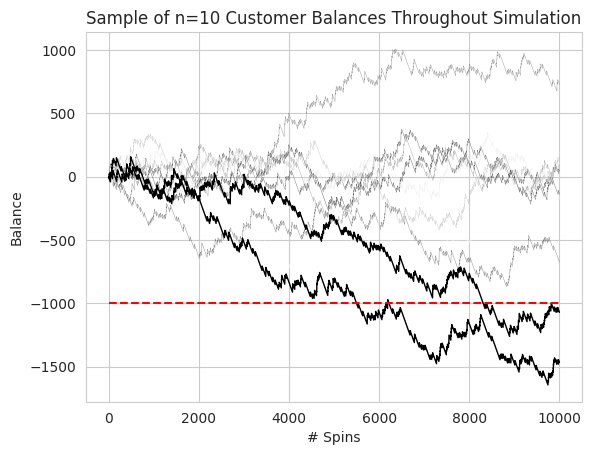

In [ ]:

# Define grayscale colors
grayscale_colors = [str(i / 10) for i in range(1, 11)]  # Generate 10 grayscale values

# Plot each list as a line
for i, (sublist, color) in enumerate(zip(x2, grayscale_colors)):
    plt.plot(sublist, color=color, alpha=0.7, linewidth=0.3)  # Set transparency with alpha
plt.plot(x2[5], color='black', alpha = 1, linewidth = 1)
plt.plot(x2[7], color='black', alpha = 1, linewidth = 1)

# Add labels, legend, and title
plt.hlines(y=-1000, xmin=0, xmax=len(x2[0]), color='red', linestyle='--')
plt.xlabel('# Spins')
plt.ylabel('Balance')
plt.title('Sample of n=10 Customer Balances Throughout Simulation')
plt.show()


How realistic is it that the highlighted customers above would continue to gamble after a sustained losings streak to less than -£1,000?

### **Budget Constraints**


---




#### **1. Hard Budget Constraint**

I have chosen -£1,000 as an arbitray starting point. Each customer will have their own appetite for risk and own budget constraints, therefore to unlock the power of this analysis, we should look to model these constraints further down the line.

First, let's analyse how many customers hit the threshold of -£1,000 out of our sample of 1,000 customers

In [ ]:
# Saving to an array flattened the shape so reshape back to 1000 customers
reshaped_data = cb1_history.reshape(1000,10000)
sub_neg_1000_customers = sum(1 for i in reshaped_data if np.any(i < -1000))
print(sub_neg_1000_customers)


174


174/1000 Customers hitting this threshold is not immaterial, what would happen if we terminated their sessions at this point? Remember the *theoretical margin* is still 2.7% but the simulated or *actual* margin will be greater if we terminate these sessions early.


In [ ]:
reshaped_data = np.where(reshaped_data < -1000, np.nan, reshaped_data)

last_balances = np.array([row[~np.isnan(row)][-1] if np.any(~np.isnan(row)) else np.nan for row in reshaped_data])


In [ ]:
print(f'original casino profit = {sum(cb2)}')
print(f'original spins = {10000*1000}')
print(f'original profit % = {sum(cb2)/(10000*1000):.3%}')
print(f'new casino profit = {-sum(last_balances)}')
print(f'new # spins = {(~np.isnan(reshaped_data)).sum()}')
print(f'new profit % = {-sum(last_balances)/((~np.isnan(reshaped_data)).sum()):.3%}')

original casino profit = 288496
original spins = 10000000
original profit % = 2.885%
new casino profit = 258976.0
new # spins = 9692258
new profit % = 2.672%


The original difference between theoretical and actual margin was +0.185%, whereas now with our hard budget constraint of quitting at -£1,000, the difference now stands at -0.028%


#### **2. Successive Losses**

Another time a customer may choose to stop transacting is when they have what they consider to be an 'unlucky spell'. On the European Roulette wheel you would expect any given number to appear 1 in every 37 spins, or 2.7% of the time. In this instance what would we consider to be an unlucky streak? 50, 60, 100 without your number coming in?

In [ ]:
success_odds = 1/37
fail_odds = 1-success_odds
cum_odds = fail_odds
cum_odds_list = []

for _ in range(3*37):
  if _ == 0:
    cum_odds = fail_odds
  else:
    cum_odds = cum_odds*fail_odds

  cum_odds_list.append(cum_odds)


I don't know a good statistical answer to this but after 3x37=111 spins, you would anticipate your number should have come up 3 times and so I will set another buffer after 111 consecutive losses.

**Note:** For any given streak of 111 consecutive spins, the odds of your number not coming up are 4.8% which feels fairly high, therefore I would still expect a reasonable number of the simulations to not experience a win.

In [ ]:
balances = cb1_history.reshape(1000,10000).astype(float)

# Step 1: Calculate differences between consecutive spins
# this produces arrays of -1 for losses and +35 for wins
# shape is (1000,9999) as expected, 9999 differences for each one of the 1000 customers
diffs = np.diff(balances, axis=1)

# Step 2: Identify streaks of consecutive decreases
# decrease_streaks creates a boolean matrix of Trues and Falses
decrease_streaks = diffs < 0  # True for decreases
# at this point consecutive decreases is being initialised
# it is just 0s in the same dimensions as decrease_streaks
consecutive_decreases = np.zeros_like(decrease_streaks, dtype=int)

# Count consecutive decreases
# this is a bit like a case statement. For every element of the streak matrix
# add one to the previous streak if True or set as 0 if false
for i in range(1, decrease_streaks.shape[1]):
    consecutive_decreases[:, i] = np.where(decrease_streaks[:, i], consecutive_decreases[:, i-1] + 1, 0)

# Step 3: Replace values in the original array when the streak is >= 111
# creates boolean of true or false in line with the streak matrix
mask = consecutive_decreases >= 111  # Mask for where streaks are >= 111
balances[:, 1:][mask] = np.nan  # Apply mask, offset by one due to np.diff

# Step 4: Get the last valid balance for each customer
last_balances_2 = np.array([row[~np.isnan(row)][-1] if np.any(~np.isnan(row)) else np.nan for row in balances])



In [ ]:
print(f'original casino profit = {sum(cb2)}')
print(f'original spins = {10000*1000}')
print(f'original profit % = {sum(cb2)/(10000*1000):.3%}')
print(f'new casino profit = {-sum(last_balances_2)}')
print(f'new # spins = {(~np.isnan(balances)).sum()}')
print(f'new profit % = {-sum(last_balances_2)/((~np.isnan(balances)).sum()):.3%}')
print(f'therefore the overall difference due to successive loss streaks is = +{-sum(last_balances_2)/((~np.isnan(balances)).sum())-0.0270:.2%}' )

original casino profit = 288496
original spins = 10000000
original profit % = 2.885%
new casino profit = 286723.0
new # spins = 9522711
new profit % = 3.011%
therefore the overall difference due to successive loss streaks is = +0.31%


Here we observe the opposite effect. In cutting customer's sessions early we have increased the profitability for the Casino. This is likely due to some winning customers who went on a large losing streak prior to achieving their max balance.

#### **3. Combination**

While the two proposed budget constraints will likely have a large degree of crossover, I think it is reasonable that most customers would be sensitive to losing in excess of £1000 or over 110 times in a row. Therefore I will combine the two criteria.


In [ ]:
def get_last_balance(balance_history_array):
  last_b = np.array([row[~np.isnan(row)][-1] if np.any(~np.isnan(row)) else np.nan for row in balance_history_array])
  return last_b

In [ ]:

# Step 1: Replace values < -1000 with NaN
balances = np.where(balances < -1000, np.nan, balances)

# Step 2: Calculate differences for consecutive losses
diffs = np.diff(balances, axis=1)

# Step 3: Identify streaks of consecutive decreases
decrease_streaks = diffs < 0  # True for decreases
consecutive_decreases = np.zeros_like(decrease_streaks, dtype=int)

# Count consecutive decreases
for i in range(1, decrease_streaks.shape[1]):
    consecutive_decreases[:, i] = np.where(decrease_streaks[:, i], consecutive_decreases[:, i-1] + 1, 0)

# Step 4: Create a combined mask for both conditions
condition1 = balances[:, 1:]  # Exclude the first column for matching size
condition2 = consecutive_decreases >= 111
combined_mask = np.isnan(condition1) | condition2

# Step 5: Replace values based on the combined mask
balances[:, 1:][combined_mask] = np.nan

# Step 6: Get the last valid balance for each customer
last_balances_3 = get_last_balance(balances)


In [ ]:
print(f'original casino profit = {sum(cb2)}')
print(f'original spins = {10000*1000}')
print(f'original profit % = {sum(cb2)/(10000*1000):.3%}')
print(f'new casino profit = {-sum(last_balances_3)}')
print(f'new # spins = {(~np.isnan(balances)).sum()}')
print(f'new profit % = {-sum(last_balances_3)/((~np.isnan(balances)).sum()):.3%}')
print(f'therefore the overall difference due to successive loss streaks & overall loss is = {-sum(last_balances_3)/((~np.isnan(balances)).sum())-0.0270:.2%}' )

original casino profit = 288496
original spins = 10000000
original profit % = 2.885%
new casino profit = 257153.0
new # spins = 9234710
new profit % = 2.785%
therefore the overall difference due to successive loss streaks & overall loss is = 0.08%


The combined effect is smaller than the absolute effect of either constraint. If we believe these constraints are realistic then in practise they will exist in opposing directions and the challenge will be to balance the positive and negative inefficiency.

#### **4. Further Budget Constraints**

In reality each customer will have their own unqiue set of circumstances that dictates whether they will place the next bet or not. This will relate to income, propensity to gamble, understanding of statistics and many more factors.

The purpose of this exercise was to prove the existence of a difference between theoretical and achieved margins when introducing a fairly reasonable constraint from the gambler's side.

## **Casino Adjusting Margin**

In a bid to increase overall profitability, the casino may wish to increase their profit margins. Holding the same **stop-gap** constraint we introduced in the Basic Roulette Game, we can see how a change in margin affects the disparity between achieved and theoretical margin.

The cumulative losses condition has been dropped because the underlying probability of losing 111 successive spins is still the same, only the payout has been changed to adjust the margin.

### **New Roulette Function**

Taking the previous function for the roulette game, we will now introduce a dynamic margin input.

In [ ]:
def european_roulette_marginated(stake=1, margin = 0.027):
    """
    Simulates a coin flip game and calculates the total winnings/losses.

    Parameters:
    - stake (float): The cost to play each round.

    Returns:
    - winnings: The amount that is returned to the player once playing the game.
    """
    # where player selection and outcome are both randomly selected numbers beteen 0-36
    player_selection = random.randint(0,36)
    outcome = random.randint(0,36)

    if outcome == player_selection:
        winnings = (36*(1-margin)) * stake
    else:
        winnings = 0 - stake

    return winnings

In [ ]:
def casino(margin, players = 1000, spins = 10000):
  balances = []
  balance_history = []

  for _ in range(players):
    total_winnings = 0
    running_history = []
    for _ in range(spins):
      total_winnings += european_roulette_marginated(margin = margin)
      # add the current balance to this customer's balance history
      running_history.append(total_winnings)
    balances.append(total_winnings)
    balance_history.append(running_history)

  # Casino perspective for plotting
  casino_balances = [-x for x in balances]

  return balances, balance_history, casino_balances

In [ ]:
# simulating double margin
cbal_dbl_margin, cbh_dbl_margin, ccb_dbl_margin = casino(margin = 0.054)

In [ ]:
print(f'{sum(ccb_dbl_margin)/(1000*10000)}')
print(f'after running the casino function, the casino balances amount to:£{sum(ccb_dbl_margin)}')

0.052555510399999984
after running the casino function, the casino balances amount to:£525555.1039999998


In [ ]:
reshaped_data_dm = np.array(cbh_dbl_margin).reshape(1000,10000)
sub_neg_1000_customers_dbl_margin = sum(1 for i in reshaped_data_dm if np.any(i < -1000))
print(sub_neg_1000_customers_dbl_margin)

297


In [ ]:
min(last_balances_2)

-1972.0

In [ ]:
def balances_with_conditions(balances):
  # Step 1: Replace values < -500 with NaN
  adjusted_balances = np.where(balances < -1000, np.nan, balances)

  # Step 2: Calculate differences for consecutive losses
  diffs = np.diff(adjusted_balances, axis=1)

  # Step 3: Identify streaks of consecutive decreases
  decrease_streaks = diffs < 0  # True for decreases
  consecutive_decreases = np.zeros_like(decrease_streaks, dtype=int)

  # Count consecutive decreases
  for i in range(1, decrease_streaks.shape[1]):
      consecutive_decreases[:, i] = np.where(decrease_streaks[:, i], consecutive_decreases[:, i-1] + 1, 0)

  # Step 4: Create a combined mask for both conditions
  condition1 = adjusted_balances[:, 1:]  # Exclude the first column for matching size
  condition2 = consecutive_decreases >= 111
  combined_mask = np.isnan(condition1) | condition2

  # Step 5: Replace values based on the combined mask
  adjusted_balances[:, 1:][combined_mask] = np.nan

  # Step 6: Get the last valid balance for each customer
  last_balances = np.nanmax(adjusted_balances, axis=1)

  return adjusted_balances, last_balances

In [ ]:
dbl_margin_balance_history, dbl_margin_balances = balances_with_conditions(reshaped_data_dm)

In [ ]:
print(f'{sum(ccb_dbl_margin)}')

525555.1039999998


In [ ]:
x5 = np.nanmax(reshaped_data_dm, axis=1)

sum(x5)

237110.8079999995

In [ ]:
print(f'original casino profit = {sum(ccb_dbl_margin)}')
print(f'original spins = {10000*1000}')
print(f'original profit % = {sum(ccb_dbl_margin)/(10000*1000):.3%}')
print(f'new casino profit = {-sum(dbl_margin_balances)}')
print(f'new # spins = {(~np.isnan(dbl_margin_balance_history)).sum()}')
print(f'new profit % = {-sum(dbl_margin_balances)/((~np.isnan(dbl_margin_balance_history)).sum()):.3%}')
print(f'therefore the overall difference due to successive loss streaks & overall loss is = {sum(dbl_margin_balances)/((~np.isnan(dbl_margin_balance_history)).sum())-0.0540:.2%}' )

original casino profit = 525555.1039999998
original spins = 10000000
original profit % = 5.256%
new casino profit = -237110.8079999995
new # spins = 9055116
new profit % = -2.619%
therefore the overall difference due to successive loss streaks & overall loss is = -2.78%


In [ ]:
original_casino_history = cb1_history.reshape(1000,10000)

def stop_gap_sim(history_array, stop_gap = 2000):
  history_array = np.where(history_array < -stop_gap, np.nan, history_array)
  stop_gap_last_balances = get_last_balance(history_array)
  total_profit = -sum(stop_gap_last_balances)
  total_stakes = (~np.isnan(history_array)).sum()
  stop_gap_return = total_profit/total_stakes
  return stop_gap, total_profit, stop_gap_return

results = []
for stop_gap in range(100,2500,100):
  result = stop_gap_sim(original_casino_history, stop_gap = stop_gap)
  results.append(result)

print(results)



[(100, -49076.0, -0.009788989003045446), (200, 10228.0, 0.0016933062748685733), (300, 62604.0, 0.009086554790166247), (400, 109276.0, 0.014400994611685395), (500, 148896.0, 0.018216412388569816), (600, 181876.0, 0.021044619670996443), (700, 209056.0, 0.023189344632799695), (800, 230372.0, 0.024715930731193388), (900, 246552.0, 0.025844892071851467), (1000, 258976.0, 0.026719883024162172), (1100, 268160.0, 0.027357710016027357), (1200, 275632.0, 0.027904799392240047), (1300, 281008.0, 0.028310952198166994), (1400, 284408.0, 0.028551485544008458), (1500, 286240.0, 0.028672091699407418), (1600, 287344.0, 0.028757529681122527), (1700, 287948.0, 0.02880558481095322), (1800, 288296.0, 0.028836771705123065), (1900, 288424.0, 0.028846721238841577), (2000, 288496.0, 0.02885146091922929), (2100, 288496.0, 0.02885085212698231), (2200, 288496.0, 0.028849871188789174), (2300, 288496.0, 0.0288496), (2400, 288496.0, 0.0288496)]


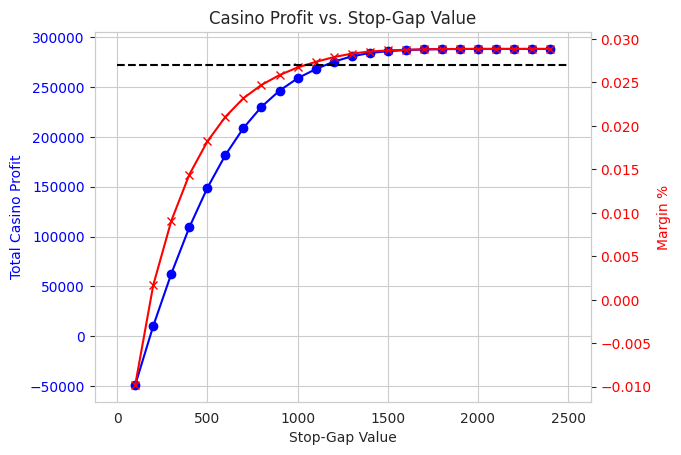

In [ ]:
# Extract x and y values from the list of tuples
x_values = [result[0] for result in results]
y_values = [result[1] for result in results]
y_values_2 = [result[2] for result in results]

fig, ax1 = plt.subplots()  # Create a figure and primary axes
ax1.plot(x_values, y_values, marker='o', color='blue')  # Plot y_values on primary axis
ax1.set_xlabel('Stop-Gap Value')
ax1.set_ylabel('Total Casino Profit', color='blue')  # Set label for primary axis
ax1.tick_params('y', labelcolor='blue')  # Set tick label color for primary axis

# Create a secondary y-axis
ax2 = ax1.twinx()  # Create a secondary axis sharing the x-axis
ax2.plot(x_values, y_values_2, marker='x', color='red')  # Plot y_values_2 on secondary axis
ax2.hlines(y=0.027, xmin=0, xmax=2500, color='black', linestyle='--')
ax2.set_ylabel('Margin %', color='red')  # Set label for secondary axis
ax2.tick_params('y', labelcolor='red')  # Set tick label color for secondary axis

plt.title('Casino Profit vs. Stop-Gap Value')
plt.grid(False)
plt.show()

In [ ]:
double_margin_casino_history = np.array(cbh_dbl_margin).reshape(1000,10000)

results_dbl = []
for stop_gap in range(100,2500,100):
  result = stop_gap_sim(double_margin_casino_history, stop_gap = stop_gap)
  results_dbl.append(result)

print(results_dbl)


[(100, 30358.34400000109, 0.00808814103546137), (200, 106650.55200000141, 0.0219270614929078), (300, 176012.68000000104, 0.03014341064561182), (400, 238260.83200000104, 0.03566668932065883), (500, 293673.3760000011, 0.0398036360265188), (600, 342573.2800000005, 0.04286266349546641), (700, 384241.50400000066, 0.045202558880208236), (800, 420045.0400000008, 0.04719019699569995), (900, 448983.2640000004, 0.04867898460743493), (1000, 471641.77600000007, 0.049738959609235744), (1100, 488707.5200000003, 0.05059222322432003), (1200, 500267.47200000024, 0.05116053107736483), (1300, 508815.16, 0.05165249141739431), (1400, 514848.3040000001, 0.05199441728492612), (1500, 518984.19999999995, 0.05219840422910466), (1600, 521881.0399999999, 0.052361404540608045), (1700, 523466.30399999977, 0.05243643303521609), (1800, 524382.864, 0.052485055833253004), (1900, 525114.2319999998, 0.052535085002285015), (2000, 525426.6639999998, 0.05255056474988188), (2100, 525555.1039999998, 0.05255568383375663), (220

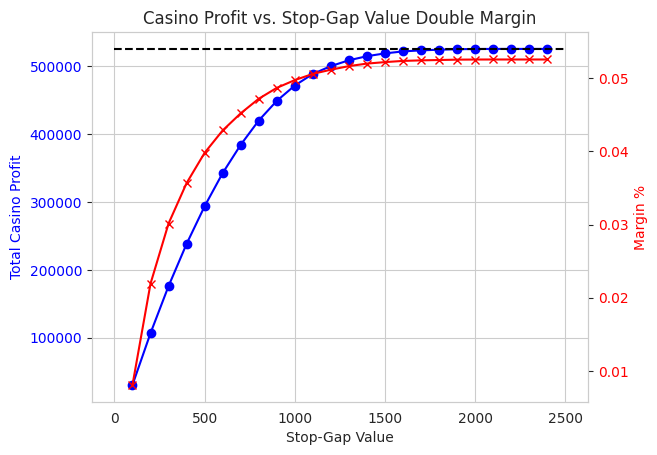

In [ ]:
# Extract x and y values from the list of tuples
x_values_dbl = [result[0] for result in results_dbl]
y_values_dbl = [result[1] for result in results_dbl]
y_values_2_dbl = [result[2] for result in results_dbl]

fig_dbl, ax1_dbl = plt.subplots()  # Create a figure and primary axes
ax1_dbl.plot(x_values_dbl, y_values_dbl, marker='o', color='blue')  # Plot y_values on primary axis
ax1_dbl.set_xlabel('Stop-Gap Value')
ax1_dbl.set_ylabel('Total Casino Profit', color='blue')  # Set label for primary axis
ax1_dbl.tick_params('y', labelcolor='blue')  # Set tick label color for primary axis

# Create a secondary y-axis
ax2_dbl = ax1_dbl.twinx()  # Create a secondary axis sharing the x-axis
ax2_dbl.plot(x_values_dbl, y_values_2_dbl, marker='x', color='red')  # Plot y_values_2 on secondary axis
ax2_dbl.hlines(y=0.054, xmin=0, xmax=2500, color='black', linestyle='--')
ax2_dbl.set_ylabel('Margin %', color='red')  # Set label for secondary axis
ax2_dbl.tick_params('y', labelcolor='red')  # Set tick label color for secondary axis

plt.title('Casino Profit vs. Stop-Gap Value Double Margin')
plt.grid(False)
plt.show()

In [ ]:
cbal_qdl_margin, cbh_qdl_margin, ccb_qdl_margin = casino(margin = 0.108)

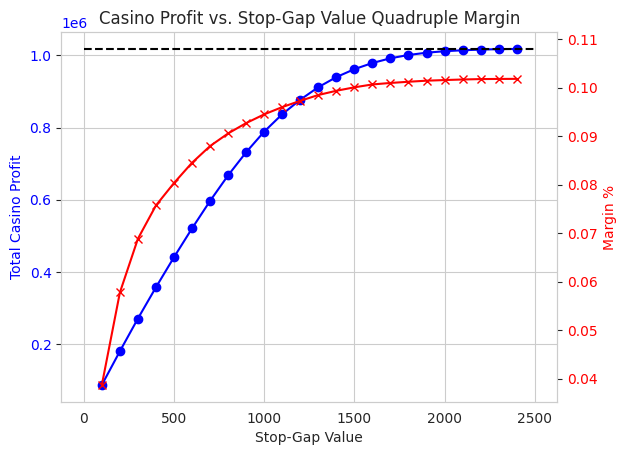

In [ ]:
qdl_margin_casino_history = np.array(cbh_qdl_margin).reshape(1000,10000)

results_qdl = []
for stop_gap in range(100,2500,100):
  result = stop_gap_sim(qdl_margin_casino_history, stop_gap = stop_gap)
  results_qdl.append(result)

# Extract x and y values from the list of tuples
x_values_qdl = [result[0] for result in results_qdl]
y_values_qdl = [result[1] for result in results_qdl]
y_values_2_qdl = [result[2] for result in results_qdl]

fig_qdl, ax1_qdl = plt.subplots()  # Create a figure and primary axes
ax1_qdl.plot(x_values_qdl, y_values_qdl, marker='o', color='blue')  # Plot y_values on primary axis
ax1_qdl.set_xlabel('Stop-Gap Value')
ax1_qdl.set_ylabel('Total Casino Profit', color='blue')  # Set label for primary axis
ax1_qdl.tick_params('y', labelcolor='blue')  # Set tick label color for primary axis

# Create a secondary y-axis
ax2_qdl = ax1_qdl.twinx()  # Create a secondary axis sharing the x-axis
ax2_qdl.plot(x_values_qdl, y_values_2_qdl, marker='x', color='red')  # Plot y_values_2 on secondary axis
ax2_qdl.hlines(y=0.108, xmin=0, xmax=2500, color='black', linestyle='--')
ax2_qdl.set_ylabel('Margin %', color='red')  # Set label for secondary axis
ax2_qdl.tick_params('y', labelcolor='red')  # Set tick label color for secondary axis

plt.title('Casino Profit vs. Stop-Gap Value Quadruple Margin')
plt.grid(False)
plt.show()

In [ ]:
cbal_t_margin, cbh_t_margin, ccb_t_margin = casino(margin = 0.3)

In [ ]:
t_margin_casino_history = np.array(cbh_t_margin).reshape(1000,10000)

results_t = []
for stop_gap in range(100,5000,100):
  result = stop_gap_sim(t_margin_casino_history, stop_gap = stop_gap)
  results_t.append(result)

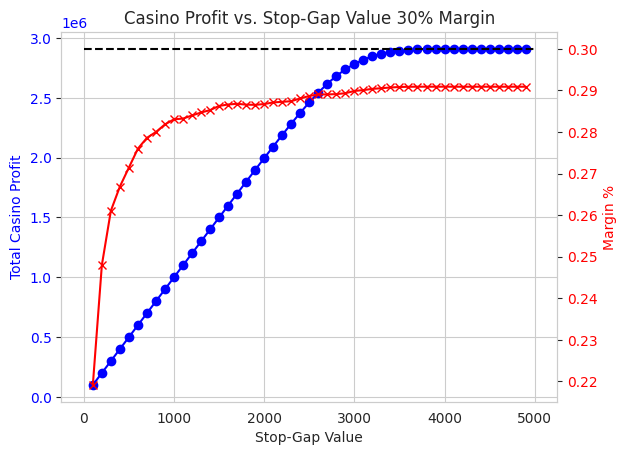

In [ ]:
# Extract x and y values from the list of tuples
x_values_t = [result[0] for result in results_t]
y_values_t = [result[1] for result in results_t]
y_values_2_t = [result[2] for result in results_t]

fig_t, ax1_t = plt.subplots()  # Create a figure and primary axes
ax1_t.plot(x_values_t, y_values_t, marker='o', color='blue')  # Plot y_values on primary axis
ax1_t.set_xlabel('Stop-Gap Value')
ax1_t.set_ylabel('Total Casino Profit', color='blue')  # Set label for primary axis
ax1_t.tick_params('y', labelcolor='blue')  # Set tick label color for primary axis

# Create a secondary y-axis
ax2_t = ax1_t.twinx()  # Create a secondary axis sharing the x-axis
ax2_t.plot(x_values_t, y_values_2_t, marker='x', color='red')  # Plot y_values_2 on secondary axis
ax2_t.hlines(y=0.3, xmin=0, xmax=5000, color='black', linestyle='--')
ax2_t.set_ylabel('Margin %', color='red')  # Set label for secondary axis
ax2_t.tick_params('y', labelcolor='red')  # Set tick label color for secondary axis

plt.title('Casino Profit vs. Stop-Gap Value 30% Margin')
plt.grid(False)
plt.show()

##Conclusion

**This effect is distorted by looking at one individual simulation and the results would be different if we ran this exercise again. To attempt to quantify this we should use a statistical approach.**